# 0. Load dependencies and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/data.csv', parse_dates=['OrderDate', 'RegistrationDate', 'LastLoginDate'])
df.head(5)

,PlayerID,OrderID,OrderDate,Price,Bonus,RegistrationDate,LastLoginDate
0,83f68e12355250e64cbd57b2e51c57ad,9deed692a4719ecbdbe6895b3f14af99,2018-12-30,46.0,0.0,2013-08-10,2020-04-27
1,788e8dcccb8757a5a7f29481ec1d6fc0,cf5bc9424768595e045fa603f251e534,2018-11-21,32.0,0.0,2015-11-04,2020-04-27
2,3332880692313818482a5a0286608ab6,6099cc1653f1fa831c6d1c7bf457b278,2019-01-23,64.0,0.0,2012-11-27,2020-03-14
3,866d051deb3437d40731901ae7fd9092,eae815dbac9ddb49fcf84c3acb52ba08,2018-12-07,46.0,0.0,2013-04-25,2019-10-15
4,7799957d4da397731b4a8d105933e57c,4bf2689c42aae35e6924a432e435e0b1,2018-11-16,36.0,0.0,2014-09-16,2020-04-27


# 1. EDA
## 1.1 Basic info and Sanitary Checks

In [3]:
# Size of data
print('Size of Data:', df.shape)
print('')

# Null and unique values
summary = pd.DataFrame({'Column Types': df.dtypes,
                        'Number of Nulls': df.isna().sum(),
                        'Unique Values': df.nunique()})
print(summary)

Size of Data: (84330, 7)

                    Column Types  Number of Nulls  Unique Values
PlayerID                  object                0          15701
OrderID                   object                0          84330
OrderDate         datetime64[ns]                0            122
Price                    float64                0            385
Bonus                    float64                0              3
RegistrationDate  datetime64[ns]                0           2522
LastLoginDate     datetime64[ns]                0            542


## 1.2 Visualizations

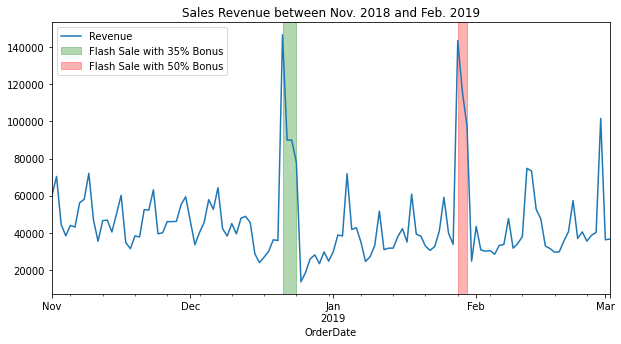

In [4]:
ax = df.groupby('OrderDate')['Price'].sum().plot(
    label='Revenue', figsize=(10, 5), title='Sales Revenue between Nov. 2018 and Feb. 2019')
ax.axvspan(pd.datetime(2018, 12, 21), pd.datetime(2018, 12, 24),
           label='Flash Sale with 35% Bonus',color='green', alpha=0.3)
ax.axvspan(pd.datetime(2019, 1, 28), pd.datetime(2019, 1, 30),
           label='Flash Sale with 50% Bonus',color='red', alpha=0.3)
ax.legend()

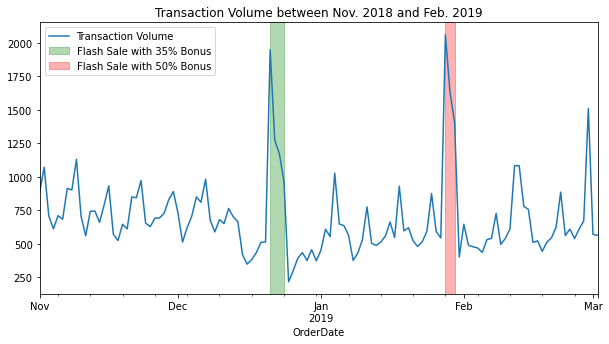

In [5]:
ax = df.groupby('OrderDate')['Price'].count().plot(
    label='Transaction Volume', figsize=(10, 5), title='Transaction Volume between Nov. 2018 and Feb. 2019')
ax.axvspan(pd.datetime(2018, 12, 21), pd.datetime(2018, 12, 24),
           label='Flash Sale with 35% Bonus',color='green', alpha=0.3)
ax.axvspan(pd.datetime(2019, 1, 28), pd.datetime(2019, 1, 30),
           label='Flash Sale with 50% Bonus',color='red', alpha=0.3)
ax.legend()

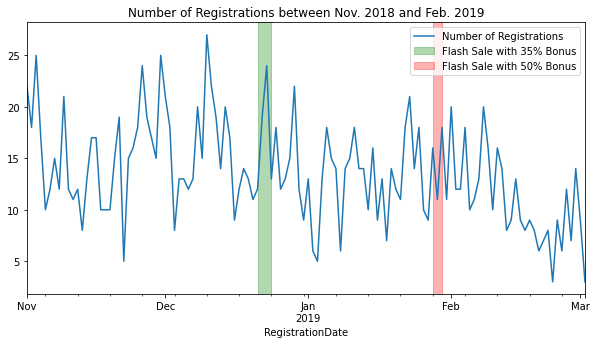

In [6]:
df_players = df[['PlayerID', 'RegistrationDate', 'LastLoginDate']].drop_duplicates()

ax = df_players[(df_players['RegistrationDate']>='2018-11-01')
                &(df_players['RegistrationDate']<='2019-03-02')].groupby(
    'RegistrationDate')['PlayerID'].count().plot(
    label='Number of Registrations', figsize=(10, 5),
    title='Number of Registrations between Nov. 2018 and Feb. 2019')
ax.axvspan(pd.datetime(2018, 12, 21), pd.datetime(2018, 12, 24),
           label='Flash Sale with 35% Bonus',color='green', alpha=0.3)
ax.axvspan(pd.datetime(2019, 1, 28), pd.datetime(2019, 1, 30),
           label='Flash Sale with 50% Bonus',color='red', alpha=0.3)
ax.legend()

In [7]:
# Segment users into 3 categories: free user, pay user and new user
df['Segment_ExPromo1'] = 'Free User'
list_Segment_ExPromo1_Pay_User = df[df['OrderDate']<='2018-12-20']['PlayerID'].to_list()
df['Segment_ExPromo1'][df['PlayerID'].isin(list_Segment_ExPromo1_Pay_User)] = 'Pay User'
list_Segment_ExPromo1_Unregistered = df[df['RegistrationDate']>'2018-12-20']['PlayerID'].to_list()
df['Segment_ExPromo1'][df['PlayerID'].isin(list_Segment_ExPromo1_Unregistered)] = 'New User'

df['Segment_ExPromo2'] = 'Free User'
list_Segment_ExPromo2_Pay_User = df[df['OrderDate']<='2019-01-27']['PlayerID'].to_list()
df['Segment_ExPromo2'][df['PlayerID'].isin(list_Segment_ExPromo2_Pay_User)] = 'Pay User'
list_Segment_ExPromo2_Unregistered = df[df['RegistrationDate']>'2019-01-27']['PlayerID'].to_list()
df['Segment_ExPromo2'][df['PlayerID'].isin(list_Segment_ExPromo2_Unregistered)] = 'New User'

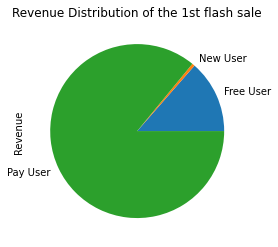

In [8]:
ax = df[df['Bonus']==0.35].groupby('Segment_ExPromo1')['Price'].sum().plot(
    kind='pie', label='Revenue',
    title='Revenue Distribution of the 1st flash sale')

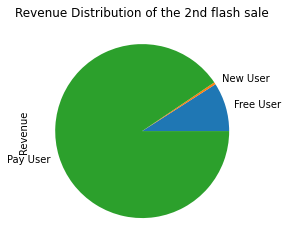

In [9]:
ax = df[df['Bonus']==0.5].groupby('Segment_ExPromo2')['Price'].sum().plot(
    kind='pie', label='Revenue',
    title='Revenue Distribution of the 2nd flash sale')

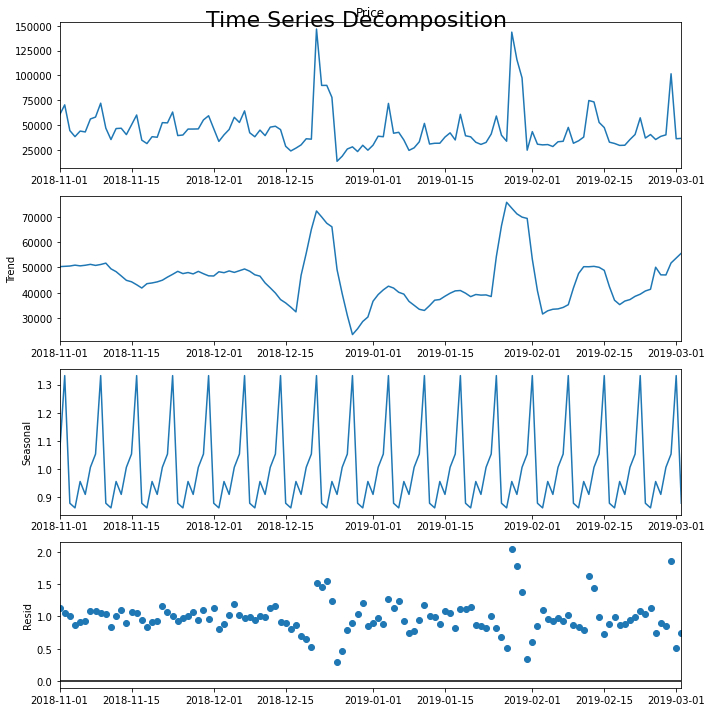

In [10]:
# Multiplicative Decomposition
result_mul = seasonal_decompose(df.groupby('OrderDate')['Price'].sum(), model='multiplicative', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10, 10)})
fig = result_mul.plot().suptitle('Time Series Decomposition', fontsize=22)
plt.rcParams.update(plt.rcParamsDefault)

# 3. Time Series Modeling

In [11]:
# Mask the weeks containing the flash sales for interpolation
ts = df.groupby('OrderDate')['Price'].sum().reset_index()
ts['Mask'] = 0
ts['Price_Masked'] = ts['Price']
ts['Mask'][(ts['OrderDate']>='2018-12-21')&(ts['OrderDate']<='2018-12-27')] = 0.35
ts['Mask'][(ts['OrderDate']>='2019-01-28')&(ts['OrderDate']<='2019-02-02')] = 0.5
ts['Price_Masked'][ts['Mask'] > 0] = np.nan

In [12]:
# Use AIC to determine the best specification
p = q = range(0, 2)
d = range(0, 2)
P = D = Q = range(0, 2)
S = [7]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, S))
specs = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(ts['Price_Masked'],
            order=param, seasonal_order=param_seasonal)
            res = model.fit(disp=0)
            specs.append([param, param_seasonal, res.aic])
        except:
            continue
specs = pd.DataFrame(specs, columns=['param', 'param_seasonal', 'aic'])
specs = specs.sort_values('aic')
specs.head()

,param,param_seasonal,aic
27,"(0, 1, 1)","(0, 1, 1, 7)",2192.201964
30,"(0, 1, 1)","(1, 1, 0, 7)",2195.542225
51,"(1, 1, 0)","(0, 1, 1, 7)",2195.681871
43,"(1, 0, 1)","(0, 1, 1, 7)",2199.567266
31,"(0, 1, 1)","(1, 1, 1, 7)",2203.496444


In [13]:
# Fit the model with the best specification
model = SARIMAX(ts['Price_Masked'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 7))
res = model.fit()
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.04280D+00    |proj g|=  1.49567D-01

At iterate    5    f=  8.99923D+00    |proj g|=  2.07562D-05

At iterate   10    f=  8.99922D+00    |proj g|=  5.58683D-04

At iterate   15    f=  8.99868D+00    |proj g|=  4.32763D-03

At iterate   20    f=  8.96071D+00    |proj g|=  2.70559D-02

At iterate   25    f=  8.95984D+00    |proj g|=  4.85390D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     29      1     0     0   

 This problem is unconstrained.


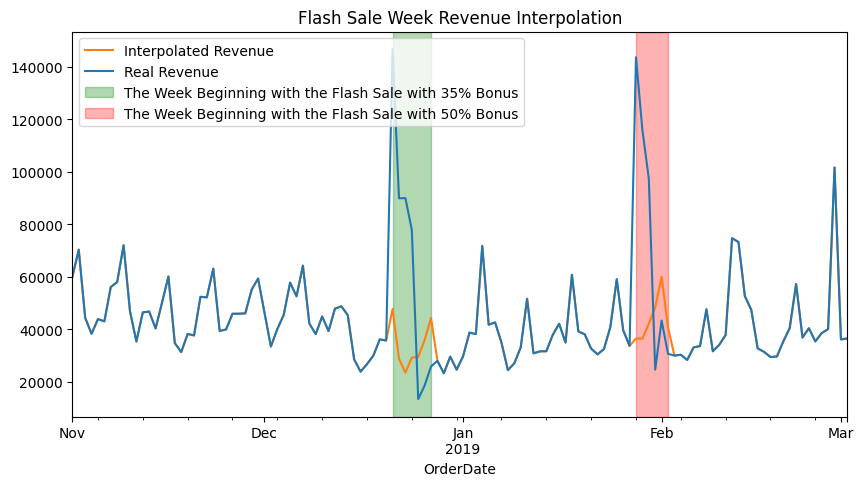

In [14]:
# Interpolate the masked dates
predict = res.get_prediction()
predict_ci = predict.conf_int()
ts['Price_Interpolated'] = ts['Price_Masked']
ts['Price_Interpolated'][ts['Mask']>0] = predict.predicted_mean

ax = ts.plot(x='OrderDate', y='Price_Interpolated', label='Interpolated Revenue',
             figsize=(10, 5), title='Flash Sale Week Revenue Interpolation', color='#ff7f0e')
ax = ts.plot(x='OrderDate', y='Price', label='Real Revenue', ax=ax,
             figsize=(10, 5), title='Flash Sale Week Revenue Interpolation', color='#1f77b4')
ax.axvspan(pd.datetime(2018, 12, 21), pd.datetime(2018, 12, 27),
           label='The Week Beginning with the Flash Sale with 35% Bonus',color='green', alpha=0.3)
ax.axvspan(pd.datetime(2019, 1, 28), pd.datetime(2019, 2, 2),
           label='The Week Beginning with the Flash Sale with 50% Bonus',color='red', alpha=0.3)
ax.legend()

In [15]:
# Calculate the effect of flash sales
ts['Difference'] = (ts['Price'] - ts['Price_Interpolated'])
ts.groupby('Mask')['Difference'].sum()

Mask
0.00         0.000000
0.35    223107.815496
0.50    191266.303132
Name: Difference, dtype: float64

# 4. Measure the validity of the interpolation

Mask
1.0   -65615.995334
Name: Difference, dtype: float64
Mask
1.0   -40903.720445
Name: Difference, dtype: float64
Mask
1.0   -16191.844023
Name: Difference, dtype: float64
Mask
1.0   -72764.229508
Name: Difference, dtype: float64


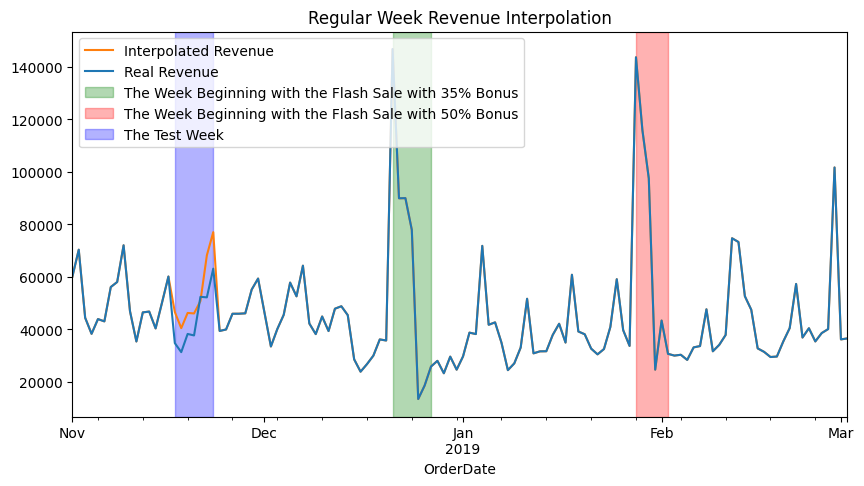

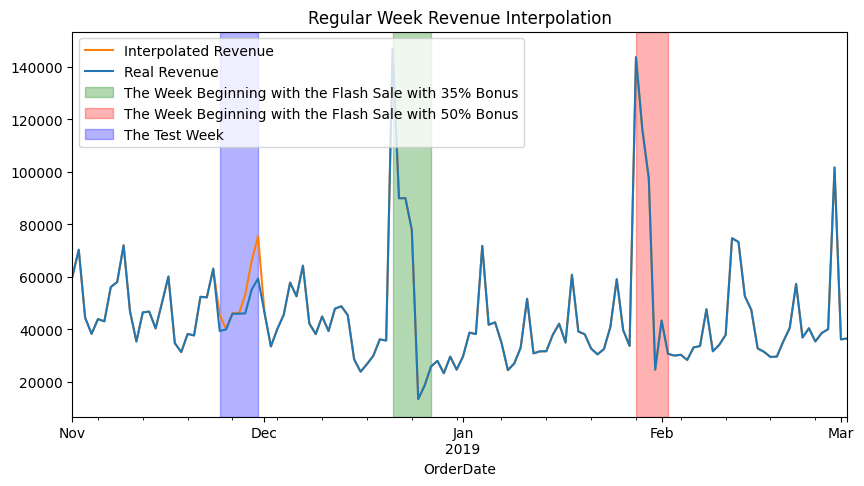

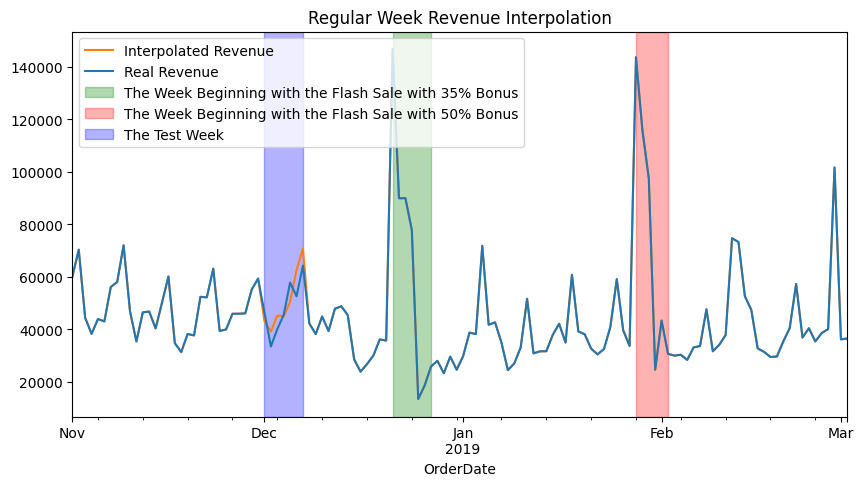

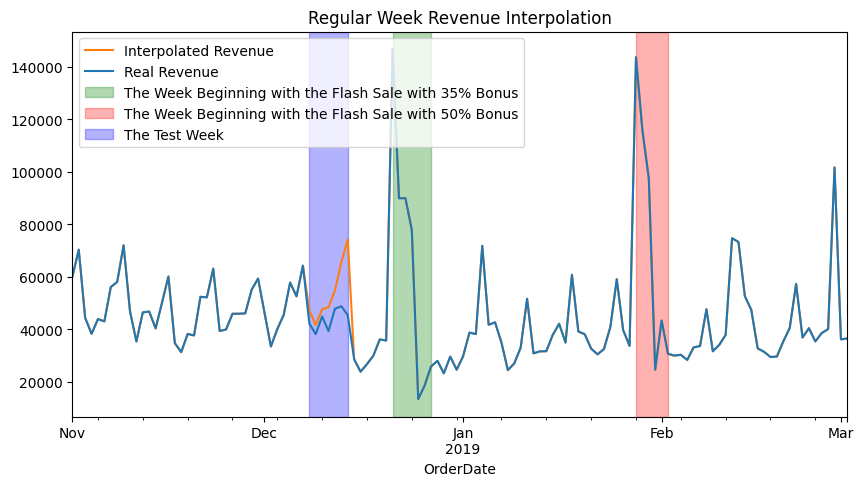

In [16]:
list_test_masks = [('2018-11-17', '2018-11-23'),
                   ('2018-11-24', '2018-11-30'),
                   ('2018-12-01', '2018-12-07'),
                   ('2018-12-08', '2018-12-14')]

for test_masks in list_test_masks:
    # Mask the weeks containing the flash sales for interpolation
    ts = df.groupby('OrderDate')['Price'].sum().reset_index()
    ts['Mask'] = 0
    ts['Price_Masked'] = ts['Price']
    ts['Mask'][(ts['OrderDate']>='2018-12-21')&(ts['OrderDate']<='2018-12-27')] = 0.35
    ts['Mask'][(ts['OrderDate']>='2019-01-28')&(ts['OrderDate']<='2019-02-02')] = 0.5
    ts['Mask'][(ts['OrderDate']>=test_masks[0])&(ts['OrderDate']<=test_masks[1])] = 1
    ts['Price_Masked'][ts['Mask'] > 0] = np.nan

    # Fit the model with the best specification
    model = SARIMAX(ts['Price_Masked'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 7))
    res = model.fit(disp=0)

    # Interpolate
    predict = res.get_prediction()
    predict_ci = predict.conf_int()
    ts['Price_Interpolated'] = ts['Price']
    ts['Price_Interpolated'][ts['Mask']==1] = predict.predicted_mean
    ax = ts.plot(x='OrderDate', y='Price_Interpolated', label='Interpolated Revenue',
             figsize=(10, 5), title='Regular Week Revenue Interpolation', color='#ff7f0e')
    ax = ts.plot(x='OrderDate', y='Price', label='Real Revenue', ax=ax,
             figsize=(10, 5), title='Regular Week Revenue Interpolation', color='#1f77b4')
    ax.axvspan(pd.datetime(2018, 12, 21), pd.datetime(2018, 12, 27),
               label='The Week Beginning with the Flash Sale with 35% Bonus',color='green', alpha=0.3)
    ax.axvspan(pd.datetime(2019, 1, 28), pd.datetime(2019, 2, 2),
               label='The Week Beginning with the Flash Sale with 50% Bonus',color='red', alpha=0.3)
    ax.axvspan(pd.to_datetime(test_masks[0]), pd.to_datetime(test_masks[1]),
               label='The Test Week',color='blue', alpha=0.3)

    ax.legend()

    # Calculate the effect of flash sales
    ts['Difference'] = (ts['Price'] - ts['Price_Interpolated'])
    print(ts.groupby('Mask')['Difference'].sum().tail(1))